100% (10999 of 10999) |##################| Elapsed Time: 0:00:24 Time:  0:00:24


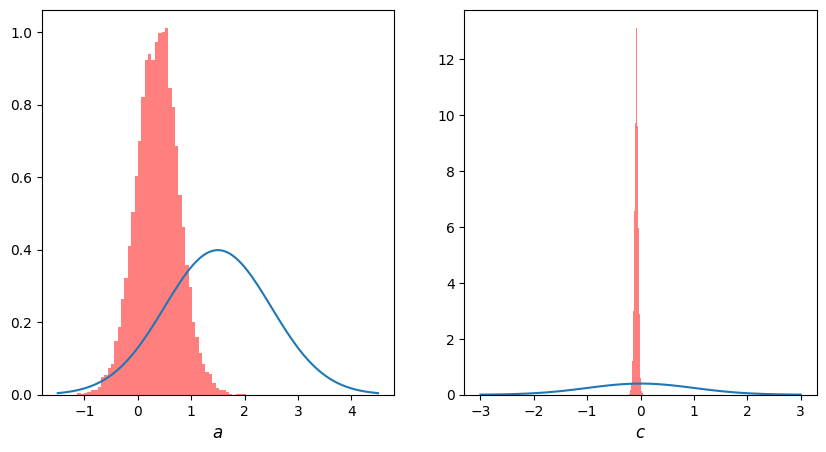

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
from progressbar import progressbar

# Seemingly unrelated regression
def sur(y, x, s, beta0, B0, nu0, V0):
    # Initialization
    m, n = y.shape
    sample = {'beta': np.zeros((s, len(beta0))), 'inv_sig': np.zeros((n, n, s))}
    sample['beta'][0, :] = beta0
    sample['inv_sig'][:, :, 0] = V0
    nu1 = nu0 + m
    
    # Sampling
    for i in progressbar(range(1, s)):
        B = np.linalg.inv(B0)
        for j in range(m):
            B += x[:, :, j].T @ sample['inv_sig'][:, :, i - 1] @ x[:, :, j]
        B1 = np.linalg.inv(B)
        beta = np.linalg.inv(B0) @ beta0.reshape(-1, 1)
        for j in range(m):
            beta += x[:, :, j].T @ sample['inv_sig'][:, :, i - 1] @ y[j, :].reshape(-1, 1)
        beta1 = B1 @ beta
        sample['beta'][i, :] = stats.multivariate_normal.rvs(size=1, mean=beta1.ravel(), cov=B1)
        
        V = np.linalg.inv(V0)
        for j in range(m):
            err = y[j, :].T - x[:, :, j] @ sample['beta'][i, :].reshape(-1, 1)
            V += err @ err.T
        V1 = np.linalg.inv(V)
        sample['inv_sig'][:, :, i] = stats.wishart.rvs(df = nu1, size=1, scale=V1)
        
    return sample

# Import policy data
with open("policy.csv", "r") as file:
    reader = csv.reader(file)
    header = next(reader)
    data = [row for row in reader]

data = np.array(data, dtype=float)
date = data[:, header.index('Date')]
y = np.zeros((len(date), 2))
y[:, 0] = data[:, header.index('INT')]
y[:, 1] = data[:, header.index('SYR')]
x = np.zeros((2, 6, len(date)))
for t in range(len(date)):
    x[0, 0, t] = 1
    x[0, 1, t] = data[t, header.index('INF')] - 2
    x[0, 2, t] = data[t, header.index('GAP')]
    x[1, 3, t] = 1
    x[1, 4, t] = data[t, header.index('lagBYR')] - 46
    x[1, 5, t] = data[t, header.index('GAP')]

# Prior and posterior
beta0 = np.array([4, 1.5, 0.5, 0, 0, 0])
B0 = np.identity(6)
nu0 = 3
V0 = np.identity(2)
sample = sur(y, x, 11000, beta0, B0, nu0, V0)
sample['beta'] = sample['beta'][1000:11000, :]
sample['inv_sig'] = sample['inv_sig'][:, :, 1000:11000]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
a = np.linspace(-1.5, 4.5, 100)
ax1.plot(a, stats.norm.pdf(a, loc=1.5, scale=1))
ax1.hist(sample['beta'][:, 1], bins=50, density=True, color="red", alpha=0.5)
ax1.set_xlabel(r'$a$', fontsize=12)
c = np.linspace(-3, 3, 100)
ax2.plot(c, stats.norm.pdf(c, loc=0, scale=1))
ax2.hist(sample['beta'][:, 4], bins=50, density=True, color="red", alpha=0.5)
ax2.set_xlabel(r'$c$', fontsize=12)
plt.show()